# Objective

The objective of this project is to analyze Megaline clients' behavior and determine which prepaid plan is more profitable based on 2018 data provided from a sample of 500 Megaline clients.

### Description of the data:

Note: Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

### Outline:
- Step 1: Upload and preview data
- Step 2: Prepare and clean data for analysis
- Step 3: Analyze the date. Extract insights on customer behavior for each plan.
- Step 4: Test two hypotheses:
    - The average prodit from users of Ultimate and Surf plans differs
    - The average profit from users in NY-NJ area is different than users from other regions.
- Step 5: Determine which prepaid plan is more profitable and provide insights


## Initialization

In [2]:
# import pandas and numpy for data preprocessing and manipulation
import pandas as pd
import numpy as np

# import the scipy package for statistical analysis
from scipy import stats as st

# import datetime package
from datetime import datetime

# statistical data visualization
import seaborn as sns
import matplotlib.pyplot as plt




## Load data

In [3]:
# Load the data files into different DataFrames
calls = pd.read_csv('/datasets/megaline_calls.csv') 
internet = pd.read_csv('/datasets/megaline_internet.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')
users = pd.read_csv('/datasets/megaline_users.csv')


# Prepare the data

## Plans

In [4]:
# General/summary information about the plans' DataFrame
plans.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
usd_monthly_pay          2 non-null int64
usd_per_gb               2 non-null int64
usd_per_message          2 non-null float64
usd_per_minute           2 non-null float64
plan_name                2 non-null object
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [5]:
# Sample of data for plans
plans.head()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


The plans dataframe accurately shows Megaline's plan information.

## Users

In [6]:
# General/summary information about the users' DataFrame
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null object
plan          500 non-null object
churn_date    34 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [7]:
# Print a sample of data for users
users.head()


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


count    500.000000
mean      45.486000
std       16.972269
min       18.000000
25%       30.000000
50%       46.000000
75%       61.000000
max       75.000000
Name: age, dtype: float64


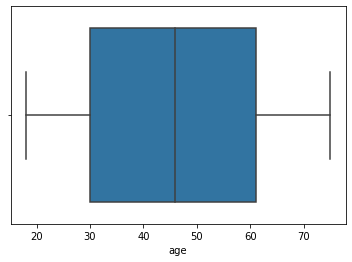

In [8]:
# Description of data
print(users.age.describe())
sns.boxplot(users['age'])
plt.show()


According to the description of the data, the users table contains data on Megaline's clients. There are missing values in churn_date column, which contains the date the client stopped using the service. If the value is missing, the client was still using the calling plan when this data was generated. This column may be dropped since only there are only 34 entries which may be insignificant to our analysis. The first_name, last_name and city columns will all be lowercased. Furthermore, the reg_date column contains string values that need to be converted to datetime objects. The average age of a Megaline client is 46 years old.

### Fix Data

[Fix obvious issues with the data given the initial observations.]

In [9]:

# Convert reg_date values to datetime
users['reg_date'] = pd.to_datetime(users['reg_date'])
users.info()

# Lowercase all string values
for columns in users.columns:
    if users[columns].dtype == object:
        users[columns] = users[columns].str.lower() 

users



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null datetime64[ns]
plan          500 non-null object
churn_date    34 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,anamaria,bauer,45,"atlanta-sandy springs-roswell, ga msa",2018-12-24,ultimate,NaN
1,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,NaN
2,1002,carlee,hoffman,36,"las vegas-henderson-paradise, nv msa",2018-10-21,surf,NaN
3,1003,reynaldo,jenkins,52,"tulsa, ok msa",2018-01-28,surf,NaN
4,1004,leonila,thompson,40,"seattle-tacoma-bellevue, wa msa",2018-05-23,surf,NaN
...,...,...,...,...,...,...,...,...
495,1495,fidel,sharpe,67,"new york-newark-jersey city, ny-nj-pa msa",2018-09-04,surf,NaN
496,1496,ariel,shepherd,49,"new orleans-metairie, la msa",2018-02-20,surf,NaN
497,1497,donte,barrera,49,"los angeles-long beach-anaheim, ca msa",2018-12-10,ultimate,NaN
498,1498,scot,williamson,51,"new york-newark-jersey city, ny-nj-pa msa",2018-02-04,surf,NaN


### Enrich Data

In [10]:
# Find percent of missing churn_date values
print("Percentage of missing churn_date values:",users['churn_date'].isna().sum()/len(users))
print()

# Dropping churn_date column
users.churn_date.isna().sum()
users = users.drop('churn_date',1)
users.info()

Percentage of missing churn_date values: 0.932

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null datetime64[ns]
plan          500 non-null object
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 27.5+ KB


93% of the clients in our analysis had missing churn_date values so they were dropped. 

## Calls

In [11]:
# Print the general/summary information about the calls' DataFrame
calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [12]:
# Sample of data for calls
print(calls.head())
print()

# Number of unique user_id values
print("Number of clients making calls:",calls.user_id.nunique())
print()

# Percentage of clients that make calls
print("Percentage of clients that make calls:",(calls.user_id.nunique() / len(users))*100)

         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22

Number of clients making calls: 481

Percentage of clients that make calls: 96.2


In [13]:
# Descriptive statistics
print(calls.duration.describe())




count    137735.000000
mean          6.745927
std           5.839241
min           0.000000
25%           1.290000
50%           5.980000
75%          10.690000
max          37.600000
Name: duration, dtype: float64


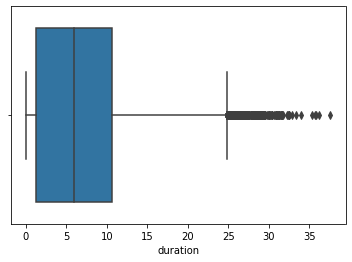

In [14]:
sns.boxplot(x=calls['duration'])
plt.show()

The call_date contains string values that need to be converted to datetime objects. There are 0 values (19%) and the boxplot confirms that there are outliers in duration column. The calls with 0 duration will be removed as these values don't reflect usage and do not generate Megaline any revenue. There are 481 clients making calls out of a possible 500 (96%). According to the description of the data, Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. The call duration column will be rounded to reflect this.



### Fix data

In [15]:
# Convert call_date column to datetime 
calls.call_date = pd.to_datetime(calls.call_date)
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null datetime64[ns]
duration     137735 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


### Enrich data

In [16]:
# Rounding duration column up and converting to int
calls.duration = calls.duration.apply(np.ceil).astype(int)
calls.head()


# Remove 0 values in call_duration column
print("Percentage of 0 call duration:",len(calls.loc[calls['duration']==0]) / len(calls))
calls = calls.loc[calls['duration']>0]

# Confirm minimum is not 0
print(calls['duration'].min() > 0)




Percentage of 0 call duration: 0.1948233927469416
True


Q1:  5.0
Q3:  12.0
IQR:  7.0
min:  0
max:  22.5
Percentage of outliers: 0.013399338148438697


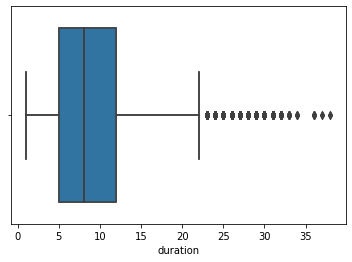

In [17]:
# Boxplot
sns.boxplot(x=calls['duration'])

# Checking for outliers in call duration

Q1 = calls['duration'].quantile(0.25)
Q3 = calls['duration'].quantile(0.75)
IQR = Q3 - Q1
print('Q1: ', Q1)
print('Q3: ', Q3)
print('IQR: ', IQR)

bottom_cutoff = Q1 - (1.5*IQR)
top_cutoff = Q3 + (1.5 * IQR)
if bottom_cutoff < 0:
    bottom_cutoff = 0
print('min: ',bottom_cutoff)
print('max: ',top_cutoff)

# How % call users reach extreme usage?
outliers_calls = calls.query('duration > @top_cutoff')
sns.boxplot(x=calls['duration'])
print("Percentage of outliers:",len(outliers_calls) / len(calls))

The upper limit of the boxplot for call duration is about 23 minutes. Less than 1% clients exceded this time. These upper outliers are actually favorable for Megaline as these clients could be bringing in a lot of extra revenue. Therefore, we want to make sure to include these upper outliers in our analysis.

## Messages

In [18]:
# Print the general/summary information about the messages' DataFrame
messages.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [19]:
# Print a sample of data for messages
print(messages.head())
print()

# Unique user_id's 
print("Number of clients sending text messages:",messages.user_id.nunique())

# Percentage of clients that send text messages
print()
print("Percentage of clients sending text messages:",(messages.user_id.nunique()/len(users)*100))

         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26

Number of clients sending text messages: 402

Percentage of clients sending text messages: 80.4


The message_date contains string values that need to be converted to datetime objects. There are 402 clients out of 500 that send text messages (80%).

### Fix data

In [20]:
# Convert message_date column to datetime
messages.message_date = pd.to_datetime(messages.message_date)
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


### Enrich data

In [21]:
# Descriptive statistics
messages.describe()


,user_id
count,76051.000000
mean,1245.972768
std,139.843635
min,1000.000000
25%,1123.000000
50%,1251.000000
75%,1362.000000
max,1497.000000


## Internet

In [22]:
# Print the general/summary information about the internet DataFrame
internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null object
mb_used         104825 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [23]:
# Sample of data for the internet traffic
print(internet.head())
print()

# Unique user_id's
print("Number of clients that use internet:",internet.user_id.nunique())
print()

# Percentage of clients that use internet
print("Percentage of clients that use internet:",(internet.user_id.nunique() / len(users))*100)

         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22

Number of clients that use internet: 489

Percentage of clients that use internet: 97.8


count    104825.000000
mean        366.713701
std         277.170542
min           0.000000
25%         136.080000
50%         343.980000
75%         554.610000
max        1693.470000
Name: mb_used, dtype: float64


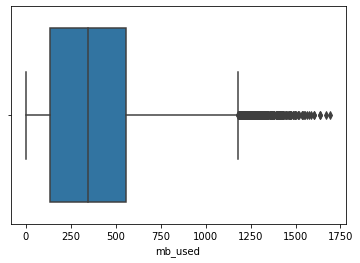

In [24]:
print(internet.mb_used.describe())
sns.boxplot(x=internet['mb_used'])
plt.show()


According to the description of the data, for web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes. There seems to be some clients with 0 mb_used. The boxplot confirms that there are outliers in the mb_used column. Session_date column will be converted to datetime. 98% of Megaline clients use internet.

### Fix data

In [25]:
# Convert session_date column to datetime
internet.session_date = pd.to_datetime(internet.session_date)
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null datetime64[ns]
mb_used         104825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


### Enrich data

[Add additional factors to the data if you believe they might be useful.]

min:  0
max:  1182.405
Q1:  136.08
Q3:  554.61
IQR:  418.53


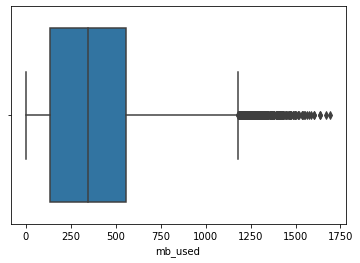

In [26]:
# Boxplot
sns.boxplot(internet['mb_used'])

# Determine upper and lower limits

Q1 = internet['mb_used'].quantile(0.25)
Q3 = internet['mb_used'].quantile(0.75)
IQR = Q3 - Q1

bottom_cutoff = Q1 - (1.5*IQR)
if bottom_cutoff < 0:
    bottom_cutoff = 0 
top_cutoff = Q3 + (1.5 * IQR)

print('min: ',bottom_cutoff)
print('max: ',top_cutoff)
print('Q1: ', Q1)
print('Q3: ', Q3)
print('IQR: ', IQR)




The upper whisker of the boxplot was about 1182 megabytes. 

In [27]:
 #How % internet users reach extreme usage?

outliers_internet = internet.query('mb_used > @top_cutoff')
print(len(outliers_internet) / len(internet))


#% internet sessions that will be drooped?
print(len(internet.loc[internet['mb_used']==0]) / len(internet))


# Filter 0 values

internet = internet.loc[internet['mb_used']>0]


# confirm minimum of these fields is no longer 0
print(internet['mb_used'].min() > 0)


0.004044836632482709
0.1311423801574052
True


13% of the clients in our analysis had 0 mb_used and were subsequently dropped from the dataset. Less than 1 of % client mb_used were outliers. These upper outliers are favorable for Megaline as these clients could be bringing in a lot of extra revenue. Therefore, we want to make sure to include these upper outliers in our analysis.

## Study plan conditions

[It is critical to understand how the plans work, how users are charged based on their plan subscription. So, we suggest printing out the plan information to view their conditions once again.]

In [28]:
# Print out the plan conditions and make sure they are clear for you

plans.head()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


# Aggregate data per user


In [29]:
# Create column to store the respective months for each call_date
calls['month'] = calls.call_date.dt.month_name()

# Calculate the number of calls made by each user per month. Save the result.
calls_per_month = calls.groupby(['user_id','month'])['duration'].count().reset_index()
calls_per_month.rename(columns={'duration':'number_of_calls'},inplace=True)
calls_per_month


,user_id,month,number_of_calls
0,1000,December,16
1,1001,August,22
2,1001,December,46
3,1001,November,49
4,1001,October,47
...,...,...,...
2251,1498,September,39
2252,1499,December,56
2253,1499,November,39
2254,1499,October,41


In [30]:
# Calculate the amount of minutes spent by each user per month. Save the result.

mins_per_month = calls.groupby(['user_id','month'])['duration'].sum().reset_index()
mins_per_month.rename(columns={'duration':'number_of_minutes'},inplace=True)
mins_per_month


,user_id,month,number_of_minutes
0,1000,December,124
1,1001,August,182
2,1001,December,412
3,1001,November,426
4,1001,October,393
...,...,...,...
2251,1498,September,363
2252,1499,December,496
2253,1499,November,308
2254,1499,October,385


Since there are outliers in call duration, the data was aggregated by median instead.


In [31]:
# Calculate the number of messages sent by each user per month. Save the result.

messages['month'] = messages.message_date.dt.month_name()
messages_per_month = messages.groupby(['user_id','month'])['id'].count().reset_index()
messages_per_month.rename(columns={'id':'number of messages'},inplace=True)
messages_per_month




,user_id,month,number of messages
0,1000,December,11
1,1001,August,30
2,1001,December,44
3,1001,November,36
4,1001,October,53
...,...,...,...
1801,1496,December,11
1802,1496,November,13
1803,1496,October,18
1804,1496,September,21


In [32]:
# Calculate the volume of internet traffic used by each user per month. Save the result.

internet['month'] = internet.session_date.dt.month_name()
internet['gb_used'] = internet['mb_used'].apply(np.ceil) # round up to mb before calculating monthly totals

webtraff_per_month = internet.groupby(['user_id','month'])['gb_used'].sum() # calculating monthly totals
webtraff_per_month = webtraff_per_month / 1025 #divide by 1025 to get GB
webtraff_per_month = webtraff_per_month.apply(np.ceil) #round up to next GB

webtraff_per_month.reset_index()


,user_id,month,gb_used
0,1000,December,2.0
1,1001,August,7.0
2,1001,December,19.0
3,1001,November,19.0
4,1001,October,22.0
...,...,...,...
2272,1498,September,23.0
2273,1499,December,22.0
2274,1499,November,17.0
2275,1499,October,20.0


Since there are outliers in call duration, the data was aggregated by median instead.


In [33]:
# Merge the data for calls, minutes, messages, internet based on user_id and month


data = users.merge(calls_per_month,how='outer',on=['user_id'])
data = data.merge(messages_per_month,how='outer',on=['user_id','month'])
data = data.merge(mins_per_month,how='outer',on=['user_id','month'])
data = data.merge(webtraff_per_month,how='outer',on=['user_id','month'])

data


,user_id,first_name,last_name,age,city,reg_date,plan,month,number_of_calls,number of messages,number_of_minutes,gb_used
0,1000,anamaria,bauer,45.0,"atlanta-sandy springs-roswell, ga msa",2018-12-24,ultimate,December,16.0,11.0,124.0,2.0
1,1001,mickey,wilkerson,28.0,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,August,22.0,30.0,182.0,7.0
2,1001,mickey,wilkerson,28.0,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,December,46.0,44.0,412.0,19.0
3,1001,mickey,wilkerson,28.0,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,November,49.0,36.0,426.0,19.0
4,1001,mickey,wilkerson,28.0,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,October,47.0,53.0,393.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2307,1407,NaN,NaN,NaN,NaN,NaT,NaN,November,NaN,1.0,NaN,1.0
2308,1482,NaN,NaN,NaN,NaN,NaT,NaN,October,NaN,2.0,NaN,NaN
2309,1094,NaN,NaN,NaN,NaN,NaT,NaN,October,NaN,NaN,NaN,2.0
2310,1108,NaN,NaN,NaN,NaN,NaT,NaN,December,NaN,NaN,NaN,1.0


In [33]:
# Add the plan information
plans.rename(columns ={'plan_name':'plan'},inplace=True)
plans.info()
data = data.merge(plans,how='left',on='plan')
data.reset_index()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
usd_monthly_pay          2 non-null int64
usd_per_gb               2 non-null int64
usd_per_message          2 non-null float64
usd_per_minute           2 non-null float64
plan                     2 non-null object
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


,index,user_id,first_name,last_name,age,city,reg_date,plan,month,number_of_calls,number of messages,number_of_minutes,gb_used,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,0,1000,anamaria,bauer,45,"atlanta-sandy springs-roswell, ga msa",2018-12-24,ultimate,December,16.0,11.0,124.0,2.0,1000,30720,3000,70,7,0.01,0.01
1,1,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,August,22.0,30.0,182.0,7.0,50,15360,500,20,10,0.03,0.03
2,2,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,December,46.0,44.0,412.0,19.0,50,15360,500,20,10,0.03,0.03
3,3,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,November,49.0,36.0,426.0,19.0,50,15360,500,20,10,0.03,0.03
4,4,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,October,47.0,53.0,393.0,22.0,50,15360,500,20,10,0.03,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2270,2270,1498,scot,williamson,51,"new york-newark-jersey city, ny-nj-pa msa",2018-02-04,surf,September,39.0,NaN,363.0,23.0,50,15360,500,20,10,0.03,0.03
2271,2271,1499,shena,dickson,37,"orlando-kissimmee-sanford, fl msa",2018-05-06,surf,December,56.0,NaN,496.0,22.0,50,15360,500,20,10,0.03,0.03
2272,2272,1499,shena,dickson,37,"orlando-kissimmee-sanford, fl msa",2018-05-06,surf,November,39.0,NaN,308.0,17.0,50,15360,500,20,10,0.03,0.03
2273,2273,1499,shena,dickson,37,"orlando-kissimmee-sanford, fl msa",2018-05-06,surf,October,41.0,NaN,385.0,20.0,50,15360,500,20,10,0.03,0.03


In [34]:
# Calculate and add gigabytes per month included with plan column
data['gb_per_month_included'] = (data['mb_per_month_included']/1000).apply(np.floor).astype(int)
data

,user_id,first_name,last_name,age,city,reg_date,plan,month,number_of_calls,number of messages,number_of_minutes,gb_used,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included
0,1000,anamaria,bauer,45,"atlanta-sandy springs-roswell, ga msa",2018-12-24,ultimate,December,16.0,11.0,124.0,2.0,1000,30720,3000,70,7,0.01,0.01,30
1,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,August,22.0,30.0,182.0,7.0,50,15360,500,20,10,0.03,0.03,15
2,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,December,46.0,44.0,412.0,19.0,50,15360,500,20,10,0.03,0.03,15
3,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,November,49.0,36.0,426.0,19.0,50,15360,500,20,10,0.03,0.03,15
4,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,October,47.0,53.0,393.0,22.0,50,15360,500,20,10,0.03,0.03,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2270,1498,scot,williamson,51,"new york-newark-jersey city, ny-nj-pa msa",2018-02-04,surf,September,39.0,NaN,363.0,23.0,50,15360,500,20,10,0.03,0.03,15
2271,1499,shena,dickson,37,"orlando-kissimmee-sanford, fl msa",2018-05-06,surf,December,56.0,NaN,496.0,22.0,50,15360,500,20,10,0.03,0.03,15
2272,1499,shena,dickson,37,"orlando-kissimmee-sanford, fl msa",2018-05-06,surf,November,39.0,NaN,308.0,17.0,50,15360,500,20,10,0.03,0.03,15
2273,1499,shena,dickson,37,"orlando-kissimmee-sanford, fl msa",2018-05-06,surf,October,41.0,NaN,385.0,20.0,50,15360,500,20,10,0.03,0.03,15


In [35]:
# Calculate the monthly revenue for each user
def monthly_revenue(row):
    monthly_charge = row['usd_monthly_pay']
    
    #call charge
    minutes = row['number_of_minutes']
    extra_minutes_fee = row['usd_per_minute']
    minutes_included = row['minutes_included']
    if minutes > minutes_included:
        call_charge = (minutes - minutes_included) * extra_minutes_fee
    else:
        call_charge = 0
    
    #message charge
    messages = row['number of messages']
    extra_msg_fee = row['usd_per_message']
    messages_included = row['messages_included']
    if messages > messages_included:
        message_charge = (messages - messages_included) * extra_msg_fee
    else:
        message_charge = 0
    
    #internet charge
    gb = row['gb_used']
    extra_gb_fee = row['usd_per_gb']
    gb_included = row['gb_per_month_included']
    if gb > gb_included:
        internet_charge = (gb - gb_included) * extra_gb_fee
    else:
        internet_charge = 0    
    
    #price
    price = monthly_charge + call_charge + message_charge + internet_charge
    return price



In [36]:
# Apply function to each user
data['monthly_revenue'] = data.apply(monthly_revenue,axis=1)



Data aggregated for each user:
- The number of calls made and minutes used per month
- The number of text messages sent per month
- The volume of data per month
- The monthly revenue from each user (subtract the free package limit from the
total number of calls, text messages, and data; multiply the result by the calling
plan value; add the monthly charge depending on the calling plan)

# Study user behaviour

In [37]:
# Separate each plan into seperate dataframe
surf = data.query('plan=="surf"')
ultimate = data.query('plan =="ultimate"')

ultimate.shape

(718, 21)

### Calls

In [38]:
# Compare average duration of calls per each plan per each distinct month.
print(data.groupby(['plan','month'])['number_of_minutes'].mean())



plan      month    
surf      April        351.540000
          August       417.849057
          December     484.501608
          February     297.000000
          January      203.000000
          July         453.733333
          June         435.791667
          March        330.000000
          May          410.240000
          November     432.494585
          October      440.891775
          September    420.732984
ultimate  April        336.857143
          August       421.436620
          December     465.261745
          February     470.333333
          January      193.500000
          July         427.067797
          June         387.444444
          March        304.250000
          May          406.241379
          November     452.320000
          October      455.028571
          September    437.511628
Name: number_of_minutes, dtype: float64


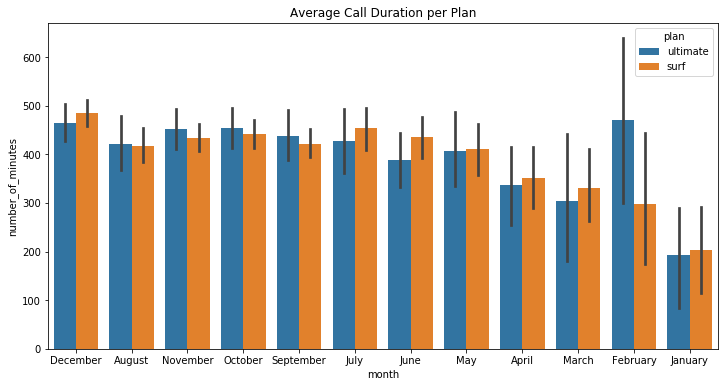

In [39]:
# Plot a bar plat to visualize
plt.figure(figsize=(12,6))
plt.title('Average Call Duration per Plan')
sns.barplot(x="month", hue="plan", y=data["number_of_minutes"], data=data)



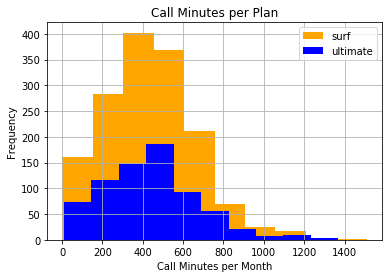

In [40]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.
data.groupby(['plan','month'])['number_of_minutes']
surf['number_of_minutes'].hist(color='orange')
ultimate['number_of_minutes'].hist(color='blue')
plt.legend(['surf','ultimate'])
plt.ylabel('Frequency')
plt.xlabel('Call Minutes per Month')
plt.title("Call Minutes per Plan")
plt.show()



In [41]:
# Calculate the mean and the variance of the monthly call duration
#print('Average monthly call duration:','\n',data.groupby(['plan'])['median_monthly_mins'].mean())
print()
print("Monthly call duration variance:",'\n')
data.groupby(['plan'])['number_of_minutes'].agg([np.mean,np.median,np.var,np.std])


Monthly call duration variance: 



,mean,median,var,std
plan,,,,
surf,436.802461,430.0,52481.561083,229.088544
ultimate,435.286517,425.5,56387.085163,237.459650


In [42]:
# Descriptive statistics for each plan
data.groupby('plan')['number_of_minutes'].describe()


,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1544.0,436.802461,229.088544,2.0,279.0,430.0,579.0,1510.0
ultimate,712.0,435.286517,237.459650,10.0,263.0,425.5,566.0,1369.0


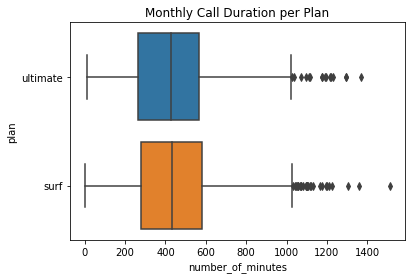

plan
surf        0.36352
ultimate    0.00000
Name: exceeds_minutes_limit?, dtype: float64

In [43]:
# Plot a boxplot to visualize the distribution of the monthly call duration
sns.boxplot(y=data['plan'], x=data["number_of_minutes"], data=data)
plt.title('Monthly Call Duration per Plan')
plt.show()

# Study user behavior
data['exceeds_minutes_limit?'] = data['number_of_minutes'] > data['minutes_included']
data.groupby('plan')['exceeds_minutes_limit?'].mean()


Due to the presence of outliers as shown in the boxplot above, the variance of the data is abnormally large and the median was used to aggregate the data. The average minutes used per month are around 400 regardless of the plan. The Ultimate and Surf plans include 1000 and 500 minutes per month respectively. Ultimate clients are barely reaching their minutes limit (3000 included). Ultimate clients never exceed their minutes included in contrast to 36% of Surf clients.

### Messages

In [44]:
# Compare the number of messages users of each plan tend to send each month

print(data.groupby(['plan'])['number of messages'].median())
print()
print(data.groupby(['plan'])['number of messages'].mean())
data.groupby(['plan'])['number of messages'].std()


plan
surf        32.0
ultimate    41.0
Name: number of messages, dtype: float64

plan
surf        39.980737
ultimate    46.534602
Name: number of messages, dtype: float64


plan
surf        33.189423
ultimate    32.904194
Name: number of messages, dtype: float64

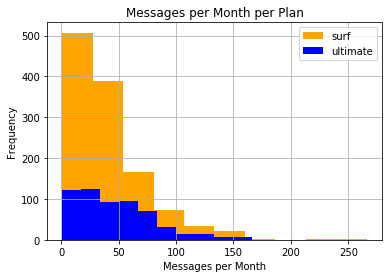

In [45]:
# Plot histogram comparing messages per month per plan
surf['number of messages'].hist(color='orange')
ultimate['number of messages'].hist(color='blue')
plt.legend(['surf','ultimate'])
plt.ylabel('Frequency')
plt.xlabel('Messages per Month')
plt.title('Messages per Month per Plan')
plt.show()

In [46]:

# Calculate the mean and the variance of the average monthly messages
print("Average monthly messages:",'\n')
data.groupby(['plan'])['number of messages'].agg([np.mean,np.median,np.var,np.std])

Average monthly messages: 



,mean,median,var,std
plan,,,,
surf,39.980737,32.0,1101.537768,33.189423
ultimate,46.534602,41.0,1082.685976,32.904194


In [47]:
# Descriptive statistics for each plan
data.groupby('plan')['number of messages'].describe()

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1194.0,39.980737,33.189423,1.0,16.0,32.0,53.0,266.0
ultimate,578.0,46.534602,32.904194,1.0,21.0,41.0,66.0,166.0


plan
surf        0.210019
ultimate    0.000000
Name: exceeds_message_limit?, dtype: float64

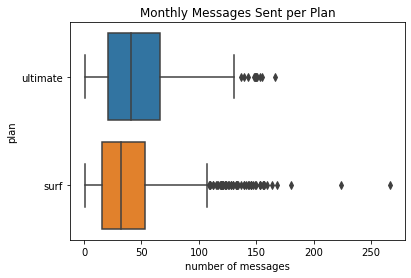

In [48]:
# Plot a boxplot to visualize the distribution of the monthly messages 
sns.boxplot(y=data["plan"], x=data["number of messages"])
plt.title('Monthly Messages Sent per Plan')

# Study clients behavior
data['exceeds_message_limit?'] = (data['number of messages'] > data['messages_included'])
data.groupby(['plan'])['exceeds_message_limit?'].mean()


Although Ultimate clients send more messages on average, these clients send an average of 46 text messages per month out of the 1000 message limit included with the plan. Similarly, Surf clients send 39 text messages per month out of the 50 message limit included with the plan. 21% Surf clients exceed their included messages and payed extra fees compared to 0% of Ultimate clients, most likely due to each plan's respective message limit.

### Internet

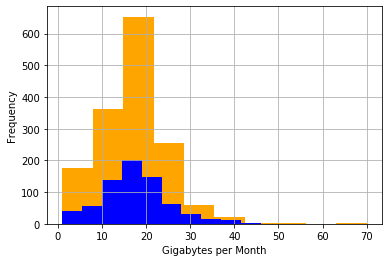

In [49]:
# Compare the amount of internet traffic consumed by users per plan
surf['gb_used'].hist(color='orange')
ultimate['gb_used'].hist(color='blue')

plt.ylabel('Frequency')
plt.xlabel('Gigabytes per Month')
plt.show()

In [50]:
# Calculate the mean and the variance of the monthly web traffic
print("Monthly web traffic variance:",'\n')
data.groupby('plan')['gb_used'].agg([np.mean, np.var, np.std])




Monthly web traffic variance: 



,mean,var,std
plan,,,
surf,16.792675,56.839842,7.539220
ultimate,17.400281,57.163038,7.560624


In [51]:
# Descriptive statistics for each plan
data.groupby('plan')['gb_used'].describe()

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1529.0,16.792675,7.539220,1.0,12.0,17.0,21.0,70.0
ultimate,712.0,17.400281,7.560624,1.0,13.0,17.0,21.0,46.0


plan
surf        0.575466
ultimate    0.055710
Name: exceeds_gb_limit?, dtype: float64

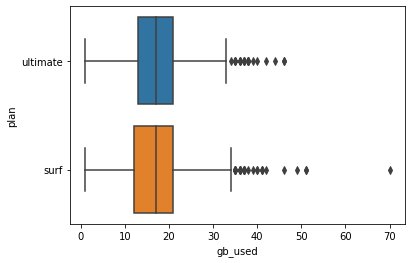

In [52]:
# Plot a boxplot to visualize the distribution of the monthly web traffic
sns.boxplot(y=data["plan"], x=data["gb_used"])

# Study clients behavior
data['exceeds_gb_limit?'] = (data['gb_used'] > data['gb_per_month_included'])
data.groupby(['plan'])['exceeds_gb_limit?'].mean()

Due to the presence of outliers as shown in the boxplot above, the median was used to aggregate the data. Both plans include 1 gb of internet per month. Over 57% Surf client exceed the gb included per month limit and payed extra fees compared to only 5% of Ultimate Clients. 

## Revenue

In [53]:
# Calculate mean and variance of monthly revenue 
data.groupby(['plan'])['monthly_revenue'].agg([np.mean,np.median,np.var,np.std])


,mean,median,var,std
plan,,,,
surf,59.816262,40.15,2856.038088,53.441913
ultimate,72.261838,70.00,128.003869,11.313880


In [54]:
# Descriptive statistics of plan data
data.groupby('plan')['monthly_revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1557.0,59.816262,53.441913,20.0,20.0,40.15,80.0,590.37
ultimate,718.0,72.261838,11.313880,70.0,70.0,70.00,70.0,182.00


In [55]:
# Percentage of clients per plan
print(data['plan'].value_counts(normalize=True))

surf        0.684396
ultimate    0.315604
Name: plan, dtype: float64


In [56]:
# Find percentage of clients per plan that pay extra fees
data['extra_fees'] = data['monthly_revenue'] - data['usd_monthly_pay']
data['pays_extra?'] = np.where(data['extra_fees']>0, True, False)
data.groupby('plan')['pays_extra?'].mean()

# Find median amount of extra fees paid per client
print("Median extra fees paid per client (USD):",data.query('extra_fees > 0')['extra_fees'].median())


Median extra fees paid per client (USD): 40.0


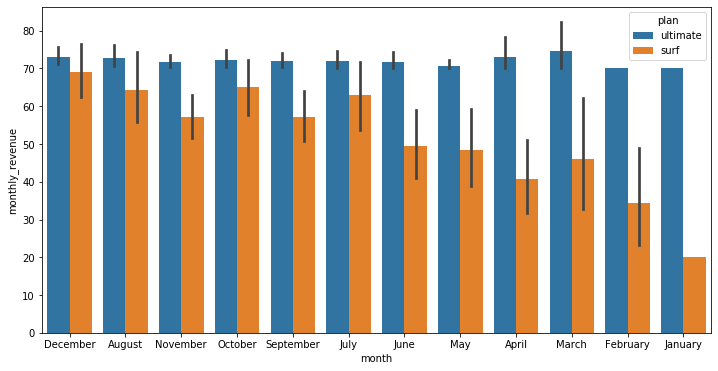

In [57]:
# Plot bar graph of monthly revenue per plan
plt.figure(figsize=(12,6))
sns.barplot(x="month", hue="plan", y=data["monthly_revenue"], data=data)
plt.show()



The average revenue for clients of the ultimate plan is \\$72 whereas the average revenue for clients of the surf plan is $59. Surf clients account for 68% of total clients. The high variance for Surf clients indicates that there are outliers in the data, which is favorable for Megaline. 

# Test statistical hypotheses

### Test 1

The null hypothesis will be what we are trying to disprove, that the profits are the same. 

- $H_o$ (Null Hypothesis): The average revenue of Surf clients will be equal to the average monthly revenue from Ultimate clients. 

- $H_A$ (Alternative Hypothesis): The average revenue from surf clients will not equal the averague monthly revenue from Ultimate clients.


In [58]:
# Test the hypotheses
alpha = .05

results = st.ttest_ind(surf['monthly_revenue'], ultimate['monthly_revenue'],equal_var = False)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")



p-value:  3.900449257166937e-18
We reject the null hypothesis


As the p-value is less than 0.05, there is a significant difference between the average monthly price of Ultimate clients vs Surf clients. Therefore, we can reject the hypothesis that the profit between the two plans is the same.

### Test 2

The null hypothesis will be what we are trying to disprove, that the profits are the same for the NY-NJ area than for the other regions. 


- $H_{0}$ (Null Hypothesis): The average revenue of  clients in the NY-NJ area will be equal to the average revenue of clients in the other regions.

- $H_{A}$ (Alternative Hypothesis): The average revenue from clients in the NY-NJ area will not equal the averague revenue from clients in the other regions.

In [59]:
# Separate NY-NJ region data from other regions
nynj_region = data.query('"new york-newark-jersey city, ny-nj-pa msa" in city')
other_regions = data.query('"new york-newark-jersey city, ny-nj-pa msa" not in city')

# Test the hypotheses
alpha = .05
results = st.ttest_ind(nynj_region['monthly_revenue'], other_regions['monthly_revenue'],equal_var = False)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")



p-value:  0.015157409965101799
We reject the null hypothesis


The p-value tells us that there is a 1% probability of randomly getting a value (average revenue of clients) that is not equal between the NY-NJ reasons and other regions. As the p-value is lower than the alpha value, we can reject the null hypothesis and can conclude that there is a significant difference among the two regions.

# General conclusion



The objective of this project is to analyze Megaline clients' behavior and determine which prepaid plan is more profitable based on 2018 data provided from a sample of 500 Megaline clients.

Below are insights discovered regarding client behavior:

- Surf clients account for 68% of total clients in contrast to 36% Ultimate clients
- 19% calls had a duration of 0 minutes and 13% internet sessions used 0 MB.
- The average call minutes used per month are around 400 regardless of the plan
- Ultimate clients are barely reaching their call minutes limit (3000 included)
- Ultimate clients never exceed their call minutes included in contrast to 35% of Surf clients
- Ultimate clients send an average of 46 text messages per month out of the 1000 message limit included with the plan. 
- Surf clients send 39 text messages per month out of the 50 message limit included with the plan. 
- 21% surf clients exceed their included messages and payed extra fees compared to 0% of Ultimate clients, most likely due to each plan's respective message limit. 
- 57% of Surf client exceed the gb included per month limit and payed extra fees compared to only 5% of Ultimate Clients. 
- 72% of Surf clients payed extra fees in contrast to 3% of Ultimate clients.
 
- The average revenue for clients of the ultimate plan is \\$71 whereas the average revenue for clients of the surf plan is $52

- Results from the hypothesis tests indicate that there is:
    - no significant difference between the average revenue of NY-NJ region and other regions. 
    - there is a significant difference between the average monthly price of ultimate clients vs surf clients
    
In conclusion, The Ultimate plan is more profitable for Megaline than the surf plan. Although Surf clients are much more likely to pay extra fees (72% percent vs 3% for ultimate), the median extra fees payed per client is around 40 USD , which is still less than the \\$70 monthly charge that ultimate clients pay. 

